In [1]:
#######################################
# CS 424 - Project 3
# Kevin Kowalski
# Samuel Kajah
# Vijay Vemu
#######################################
#
# This file contains the code to clean
# the original data set. It outputs
# the necessary plots and updated data
# set to be used by shiny.
#
# This file was used for testing and 
# plotting before using RStudio for a
# dashboard.
#
#######################################

In [2]:
# import libraries
library(comprehenr)
library(dplyr)
library(ggplot2)
library(hashmap)
library(lubridate)
library(stringr)
library(tidyverse)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Attaching package: ‘lubridate’


The following object is masked from ‘package:base’:

    date


── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ tibble  3.0.0     ✔ purrr   0.3.3
✔ tidyr   1.0.2     ✔ forcats 0.4.0
✔ readr   1.3.1     

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ lubridate::as.difftime() masks base::as.difftime()
✖ lubridate::date()        masks base::date()
✖ dplyr::filter()          masks stats::filter()
✖ lubridate::intersect()   masks base::intersect()
✖ dplyr::lag()             masks stats::lag()
✖ lubridate::setdiff()     masks base::setdiff()
✖ lubridate::union()       masks base::union()



In [79]:
# read in the combined RDS file
data <- readRDS(file = "combined_data.rds")

# LEAVE COMMENTED, UNLESS YOU NEED TO REMAKE FILE
# keywords table only for movies found in combined data table
# df_keywords = read.csv('./data_files/new_files/keywords.csv')
# keywords_subset <- subset(df_keywords, movie %in% data$movie)
# write.csv(keywords_subset, file = 'keywords_subset.csv')

# read in the subsetted keywords CSV file
keywords_subset = read.csv('keywords_subset.csv')

In [80]:
# output number of entries in data
total_data <- count(data)
print(paste0("---- data, n=", total_data))
unique_films <- length(unique(data$movie))
print(paste0("---- unique movies, n=", unique_films))

[1] "---- data, n=334427"
[1] "---- unique movies, n=36596"


In [81]:
# get list of movies where none is duplicated (used for times where you only want to account for a movie once, such as runtime average)
unique_movies <- subset(data, !duplicated(subset(data, select = movie)))

In [82]:
# preview the top 5 rows
head(data, 5)

# get a random sample of 5 rows
sample_n(data, 5)

,movie,year,month,genre,runtime,rating
,<chr>,<int>,<fct>,<fct>,<dbl>,<fct>
214,#FollowFriday (2016),2016,September,Thriller,90,USA:Unrated
698,$ (1971),1971,December,Comedy,121,USA:R
700,$ (1971),1971,December,Crime,121,USA:R
702,$ (1971),1971,December,Drama,121,USA:R
714,$10 Raise (1935),1935,May,Comedy,70,USA:Approved


movie,year,month,genre,runtime,rating
<chr>,<int>,<fct>,<fct>,<dbl>,<fct>
The Sure Thing (1985),1985,May,Drama,100,USA:PG-13
Mannequin (1937),1937,December,Drama,95,USA:Passed
Fever Pitch (2005),2005,August,Romance,104,USA:PG-13
Heart of the Golden West (1942),1942,November,Comedy,65,USA:Approved
Cat-Women of the Moon (1953),1953,September,Sci-Fi,64,USA:Approved


In [83]:
# get min and max years
min_year_all <- min(data$year)
max_year_all <- max(data$year)
print(paste0("---- years range from: ", min_year_all, "-", max_year_all))

[1] "---- years range from: 1912-2019"


In [84]:
# get min and max decades
min_decade_all <- floor(min(data$year) / 10) * 10
max_decade_all <- floor(max(data$year) / 10) * 10
print(paste0("---- decades range from: ", min_decade_all, "-", max_decade_all))

[1] "---- decades range from: 1910-2010"


In [85]:
# get min and max runtimes
min_runtime_all <- min(data$runtime)
max_runtime_all <- max(data$runtime)
print(paste0("---- runtimes range from: ", min_runtime_all, "-", max_runtime_all, " minutes"))

[1] "---- runtimes range from: 60-453 minutes"


In [86]:
############## COUNT/DISTRIBUTION TABLES BELOW ##############

In [87]:
# function to get a count of movies from each year as a table (same as above)
number_films_per_year = function(table) {
    
    # create empty dataframe of all years in range from calculated min to max
    all_years <- data.frame(formatC(min_year_all:max_year_all, width = 2), 0)
    names(all_years)[1] <- "year"
    names(all_years)[2] <- "count"
    all_years$year <- c(min_year_all:max_year_all)
    
    # make dataframe of available years and their frequency
    by_year <- table %>% group_by(year) %>% summarize(count = n())
    
    # join the counts into the full range of years dataframe
    by_year <- full_join(all_years, by_year, by = "year")
    by_year[is.na(by_year)] <- 0
    by_year$count.x <- NULL
    names(by_year)[2] <- "count"
    
    # output info
    total_films = as.numeric(sum(by_year$count))
    print(paste0("---- total counted= ", total_films))
    unique_years = as.numeric(count(by_year))
    print(paste0("---- unique years= ", unique_years))
    
    # return the table of counts per year
    by_year
}

# function to get a count of movies from each decade as a table
number_films_per_decade = function(table) {
    
    # create empty dataframe of each decade in range from calculated min to max
    all_decades <- data.frame(formatC(1:((max_decade_all - min_decade_all) / 10 + 1), width = 2), 0)
    names(all_decades)[1] <- "decade"
    names(all_decades)[2] <- "count"
    all_decades$decade <- seq(from = min_decade_all, to = max_decade_all, by = 10)
    
    # INEFFICIENT NESTED LOOP, IDEALLY A GROUP_BY OR SOMETHING BETTER
    # loop through each movie in given table
    for (row in 1:as.numeric(count(table))) {
        
        # get the current movie's decade it belongs to
        curr_decade = floor(table$year[row] / 10) * 10
        
        # loop through each decade
        for (i in 1:as.numeric(count(all_decades))) {
            
            # increment the decade count for found decade
            if (curr_decade == all_decades$decade[i]) {
                all_decades$count[i] <- all_decades$count[i] + 1
                break
            }
        }
    }
    
    # output info
    total_films = as.numeric(sum(all_decades$count))
    print(paste0("---- total counted= ", total_films))
    unique_decades = as.numeric(count(all_decades))
    print(paste0("---- unique decades= ", unique_decades))
    
    # return the table of counts per decade
    all_decades
}

# function to get a count of movies from each month as a table
number_films_per_month = function(table) {
    
    # get a count of movies from each month
    by_month <- table %>% group_by(month) %>% summarize(count = n())

    # reorder months to be in order
    by_month$month <- factor(by_month$month, levels = c("January", "February", "March", "April", "May", "June", "July", "August", "September", "October", "November", "December"))
    by_month <- by_month[order(by_month$month), ]

    # output info
    by_month
    print(paste0("---- total counted= ", sum(by_month$count)))
    unique_months = as.numeric(count(by_month))
    print(paste0("---- unique months= ", unique_months))
    
    # return the table of counts per month
    by_month
}

# function to get a distribution of runtimes as a table
distribution_of_runtimes = function(table) {
    
    # create empty dataframe of all runtimes in range from min to max
    all_runtimes <- data.frame(formatC(min_runtime_all:max_runtime_all, width = 2), 0)
    names(all_runtimes)[1] <- "runtime"
    names(all_runtimes)[2] <- "count"
    all_runtimes$runtime <- c(min_runtime_all:max_runtime_all)

    # make dataframe of available runtimes and their frequency
    by_runtime <- table %>% group_by(runtime) %>% summarize(count = n())

    # join the counts into the full range of years dataframe
    by_runtime <- full_join(all_runtimes, by_runtime, by = "runtime")
    by_runtime[is.na(by_runtime)] <- 0
    by_runtime$count.x <- NULL
    names(by_runtime)[2] <- "count"

    # output info
    head(by_runtime, 10)
    print(paste0("---- total counted= ", sum(by_runtime$count)))
    unique_runtimes = as.numeric(count(by_runtime))
    print(paste0("---- unique runtimes= ", unique_runtimes))
    
    # return the distribution of runtimes
    by_runtime
}

# function to get a distribution of certificates as a table
distribution_of_certificates = function(table) {
    
    # get a distribution of certificate
    by_certificates <- table %>% group_by(rating) %>% summarize(count = n())

    # output info
    print(paste0("---- total counted= ", sum(by_certificates$count)))
    unique_certificates = as.numeric(count(by_certificates))
    print(paste0("---- unique certificates= ", unique_certificates))
    
    # return the distribution of certificates
    by_certificates
}

# function to get a distribution of genres as a table
distribution_of_genres = function(table) {
    
    # get a distribution of genres
    by_genre <- table %>% group_by(genre) %>% summarize(count = n())

    # output info
    print(paste0("---- total counted= ", sum(by_genre$count)))
    unique_genres = as.numeric(count(by_genre))
    print(paste0("---- unique genres= ", unique_genres))
    
    # return the distribution of genres
    by_genre
}

# function to get a distribution of top n keywords as a table
distribution_of_keywords = function(table, n) {

    # get a distribution of top n keywords
    by_keywords <- table %>% group_by(keyword) %>% summarize(count = n())

    # output info
    by_keywords <- top_n(by_keywords, n) %>% arrange(desc(count))
    print(paste0("---- total counted= ", sum(by_keywords$count)))
    unique_keywords = as.numeric(count(by_keywords))
    print(paste0("---- unique keywords= ", unique_keywords))
    
    # return the distribution of top n keywords
    by_keywords
}


In [88]:
# get a count of movies from each year (for entire data (of unique movies))
by_year <- number_films_per_year(unique_movies)
sample_n(by_year, 5)

[1] "---- total counted= 36596"
[1] "---- unique years= 108"


year,count
<int>,<int>
1939,371
1947,320
1982,312
1997,554
1973,411


In [89]:
# get a count of movies from each decade (for entire data (of unique movies), takes a minute)
by_decade <- number_films_per_decade(unique_movies)
by_decade

[1] "---- total counted= 36596"
[1] "---- unique decades= 11"


decade,count
<dbl>,<dbl>
1910,34
1920,494
1930,3031
1940,3049
1950,2475
1960,1583
1970,3517
1980,3754
1990,4916


In [90]:
# get rows for a movie by partial name (can exclude year from its name)
# lots of movies have differing release months for some reason
# this SHOULD output 3 rows, 1 for each genre but many release months prevents this :(
jw2 <- data[str_detect(data$movie, "John Wick: Chapter 2"), ]
jw2

,movie,year,month,genre,runtime,rating
,<chr>,<int>,<fct>,<fct>,<dbl>,<fct>
1119397,John Wick: Chapter 2 (2017),2017,January,Action,122,USA:R
1119398,John Wick: Chapter 2 (2017),2017,February,Action,122,USA:R
1119462,John Wick: Chapter 2 (2017),2017,March,Action,122,USA:R
1119465,John Wick: Chapter 2 (2017),2017,April,Action,122,USA:R
1119466,John Wick: Chapter 2 (2017),2017,May,Action,122,USA:R
1119468,John Wick: Chapter 2 (2017),2017,July,Action,122,USA:R
1119469,John Wick: Chapter 2 (2017),2017,January,Crime,122,USA:R
1119470,John Wick: Chapter 2 (2017),2017,February,Crime,122,USA:R
1119534,John Wick: Chapter 2 (2017),2017,March,Crime,122,USA:R


In [91]:
# !!!
# since most movies have several months/genres as listed above, the leftover month
# from the unique_films table might not be correct so the months table below is skewed
# !!!

# get a count of movies from each month (for entire data (of unique movies))
by_month <- number_films_per_month(unique_movies)
by_month

[1] "---- total counted= 36596"
[1] "---- unique months= 12"


month,count
<fct>,<int>
January,3150
February,2511
March,3105
April,3082
May,3485
June,2651
July,2410
August,2921
September,4453


In [92]:
# get a distribution of runtimes
by_runtime <- distribution_of_runtimes(unique_movies)
sample_n(by_runtime, 5)

[1] "---- total counted= 36596"
[1] "---- unique runtimes= 395"


runtime,count
<dbl>,<dbl>
392,0
121,139
161,11
86,750
288,1


In [93]:
# get a distribution of certificate
by_certificates <- distribution_of_certificates(unique_movies)
by_certificates

[1] "---- total counted= 36596"
[1] "---- unique certificates= 12"


rating,count
<fct>,<int>
USA:(Banned),1
USA:12,4
USA:AO,3
USA:Approved,6604
USA:G,1175
USA:GP,186
USA:Open,9
USA:Passed,2776
USA:PG,4418


In [94]:
# get a distribution of genres
by_genre <- distribution_of_genres(unique_movies)
by_genre

[1] "---- total counted= 36596"
[1] "---- unique genres= 22"


genre,count
<fct>,<int>
Action,6226
Adventure,2399
Animation,294
Biography,1172
Comedy,9399
Crime,2834
Documentary,1255
Drama,8243
Family,161


In [95]:
# get a distribution of top n keywords
n = 10
by_keywords <- distribution_of_keywords(keywords_subset, n)
by_keywords

Selecting by count



[1] "---- total counted= 56048"
[1] "---- unique keywords= 10"


keyword,count
<fct>,<int>
independent-film,8987
murder,8281
death,5430
female-nudity,5256
husband-wife-relationship,5138
violence,4920
based-on-novel,4738
blood,4523
cigarette-smoking,4398


In [96]:
############## AVERAGES BELOW ##############

In [97]:
# get average films per year, month, and average runtime

# average fims per year: sum of films divided by total years observed
#avg_per_year = trunc(total_films / unique_years)
unique_years = as.numeric(count(by_year))
avg_per_year = trunc(unique_films / unique_years)
print(paste0("---- avg films per year= ", avg_per_year))

# average films per month: sum of films each month, each sum divided by total years observed; then average these results
unique_months = as.numeric(count(by_month))
avg_by_month <- by_month
avg_by_month$count <- by_month$count / unique_years
names(avg_by_month)[2] <- "average"
avg_per_month = trunc(as.numeric(sum(avg_by_month$average) / unique_months))
print(paste0("---- avg films per month= ", avg_per_month))
avg_by_month

# average runtime: sum of each runtime divided by total runtime observations
avg_runtime = trunc(mean(unique_movies$runtime))
print(paste0("---- avg runtime= ", avg_runtime))

[1] "---- avg films per year= 338"
[1] "---- avg films per month= 28"


month,average
<fct>,<dbl>
January,29.16667
February,23.25000
March,28.75000
April,28.53704
May,32.26852
June,24.54630
July,22.31481
August,27.04630
September,41.23148


[1] "---- avg runtime= 95"


In [98]:
############## CHOOSE YEAR OR DECADE ##############

In [99]:
# get items by year
selected_year = 2011

# USE THIS ONE TO FETCH MOVIES BY YEAR FROM THEIR NAME (I noticed some movies have a different year than in the name, but possibly not in this combined table)
# movie year found in movie name i.e. "{Title} (2014)" or "{Title} (2014/I)", extract year via pattern matching because year column is inaccurate for some reason
#regex_year = paste0("\\(", selected_year, "\\)|\\(", selected_year, "\\/")
#movies_in_selected_year <- subset(data, grepl(regex_year, movie))

# fetch the movies by the selected year
movies_in_selected_year <- subset(data, year == selected_year)

# output a sample of movies found for given year
sample_n(movies_in_selected_year, 10)

movie,year,month,genre,runtime,rating
<chr>,<int>,<fct>,<fct>,<dbl>,<fct>
Apart (2011/I),2011,February,Mystery,85,USA:Unrated
Elles (2011),2011,September,Drama,99,USA:Unrated
Killer Elite (2011),2011,December,Action,116,USA:R
Transformers: Dark of the Moon (2011),2011,August,Sci-Fi,154,USA:PG-13
Colombiana (2011),2011,December,Action,112,USA:PG-13
Rise of the Planet of the Apes (2011),2011,August,Action,105,USA:PG-13
Beastly (2011),2011,March,Drama,86,USA:PG-13
Dorfman (2011),2011,October,Comedy,92,USA:PG-13
30 Minutes or Less (2011),2011,December,Action,83,USA:R


In [100]:
# get items by decade (where decades are in format of 1990, 2000, 2010, etc... for next 9 years, i.e. 1990-1999, 2000-2009, etc..)
selected_decade = 2010

# USE THIS ONE TO FETCH MOVIES BY YEAR FROM THEIR NAME
# movie year found in movie name i.e. "{Title} (2014)" or "{Title} (2014/I)", extract decade via pattern matching for decade + 9
#regex_decade = paste0("\\(", selected_decade / 10, "[0-9]\\)|\\(", selected_decade / 10, "[0-9]\\/")
#movies_in_selected_decade <- subset(data, grepl(regex_decade, movie))

# fetch the movies by the selected year
movies_in_selected_decade <- subset(data, year >= selected_decade & year < selected_decade + 10)

# output a sample of movies found for given year
sample_n(movies_in_selected_decade, 10)

movie,year,month,genre,runtime,rating
<chr>,<int>,<fct>,<fct>,<dbl>,<fct>
German Angst (2015),2015,April,Horror,112,USA:R
Inescapable (2012),2012,September,Action,93,USA:R
Wonder Wheel (2017),2017,October,Drama,101,USA:PG-13
The Odd Life of Timothy Green (2012),2012,October,Drama,105,USA:PG
Planes: Fire & Rescue (2014),2014,July,Adventure,83,USA:PG
Sun Belt Express (2014),2014,June,Drama,91,USA:Unrated
Svartur á leik (2012),2012,March,Thriller,104,USA:R
Los últimos días (2013),2013,December,Sci-Fi,100,USA:Unrated
Autoreiji: Biyondo (2012),2012,October,Crime,112,USA:R


In [101]:
############## CHOOSE GENRE ##############

In [102]:
# genre input is comma separated string list
selected_genres = "comedy, Drama , fake_test, doCumenTarY, "

# split genres input to individual inputs
genres <- unlist(strsplit(selected_genres, ","))

# retrieve first genre as a "base"
condition <- paste0("str_to_lower(str_trim(genres[1])) == str_to_lower(genre) ")

# if more than 1 genres provided...
if (length(genres) > 1) {
    
    # then build conditional string for each one after "base"
    for (i in 2:length(genres)) {
        
        # make a new condition with the current genre, being sure to ignore case and trim the input
        next_condition <- paste0("| str_to_lower(str_trim(genres[", i, "])) == str_to_lower(genre) ")
        
        # add the new condition onto the current list of conditions
        condition <- paste(condition, next_condition, sep = "")
    }
}

# movie genre found in genre column, just fetch it by parsing the condition from above
movies_in_selected_genre <- subset(data, eval(parse(text = condition)))

# output a sample of movies found for given genre(s)
sample_n(movies_in_selected_genre, 10)

movie,year,month,genre,runtime,rating
<chr>,<int>,<fct>,<fct>,<dbl>,<fct>
My First Wedding (2006),2006,August,Comedy,94,USA:PG-13
Mujeres al borde de un ataque de nervios (1988),1988,March,Comedy,88,USA:R
The Last Lions (2011),2011,October,Documentary,88,USA:PG
Onibaba (1964),1964,November,Drama,105,USA:Unrated
A Little Romance (1979),1979,July,Comedy,110,USA:PG
Tight Spot (1955),1955,July,Drama,97,USA:Approved
City Lights (1931),1931,December,Comedy,87,USA:Passed
The Big Show (1961),1961,May,Drama,113,USA:Approved
The Forgotten Village (1941),1941,November,Documentary,67,USA:Approved


In [103]:
# number of films released in selected genre
number_in_genre <- length(unique(movies_in_selected_genre$movie))
print(paste0("---- films in genre= ", number_in_genre))

[1] "---- films in genre= 27448"


In [104]:
# table above can have duplicate movies due to movies having multiple genres or months
# get a subset of those movies where a movie only appears once
unique_movies_in_genre <- subset(movies_in_selected_genre, !duplicated(subset(movies_in_selected_genre, select = movie)))

# table of "number of films released in that genre each year" (total_counted value should match number_in_x value)
films_per_year_by_selected_genre <- number_films_per_year(unique_movies_in_genre)

# output a sample of 5 rows
sample_n(films_per_year_by_selected_genre, 5)

[1] "---- total counted= 27448"
[1] "---- unique years= 108"


year,count
<int>,<dbl>
1975,253
1987,371
1921,12
1918,4
1999,502


In [105]:
# get "percentage of films released in that genre each year"

# add total films per year to table and calculuate percentage
films_per_year_by_selected_genre$total <- by_year$count
films_per_year_by_selected_genre$percent <- (films_per_year_by_selected_genre$count / by_year$count) * 100

# output a sample of 5 rows
sample_n(films_per_year_by_selected_genre, 5)

year,count,total,percent
<int>,<dbl>,<int>,<dbl>
1997,429,554,77.43682
2005,583,722,80.74792
2015,611,791,77.24399
1944,208,273,76.19048
1989,355,508,69.88189


In [106]:
# table of "number of films released in that genre each decade" (total_counted value should match number_in_x value)
films_per_decade_by_selected_genre <- number_films_per_decade(unique_movies_in_genre)

# output a sample of 5 rows
sample_n(films_per_decade_by_selected_genre, 5)

[1] "---- total counted= 27448"
[1] "---- unique decades= 11"


decade,count
<dbl>,<dbl>
1950,1549
1920,394
1980,2758
2000,5915
1990,3760


In [107]:
# get "percentage of films released in that genre each decade"

# add total films per decade to table and calculuate percentage
films_per_decade_by_selected_genre$total <- by_decade$count
films_per_decade_by_selected_genre$percent <- (films_per_decade_by_selected_genre$count / by_decade$count) * 100

# show output
films_per_decade_by_selected_genre

decade,count,total,percent
<dbl>,<dbl>,<dbl>,<dbl>
1910,23,34,67.64706
1920,394,494,79.75709
1930,2379,3031,78.48895
1940,2288,3049,75.04100
1950,1549,2475,62.58586
1960,1135,1583,71.69931
1970,2613,3517,74.29628
1980,2758,3754,73.46830
1990,3760,4916,76.48495


In [108]:
# table of "number of films released in that genre each month" (total_counted value should match number_in_x value)
films_per_month_by_selected_genre <- number_films_per_month(unique_movies_in_genre)

# output a sample of 5 rows
sample_n(films_per_month_by_selected_genre, 5)

[1] "---- total counted= 27448"
[1] "---- unique months= 12"


month,count
<fct>,<int>
February,1906
December,1988
April,2289
July,1645
June,1971


In [109]:
# get "percentage of films released in that genre each month"

# add total films per month to table and calculuate percentage
films_per_month_by_selected_genre$total <- by_month$count
films_per_month_by_selected_genre$percent <- (films_per_month_by_selected_genre$count / by_month$count) * 100

# show output
films_per_month_by_selected_genre

month,count,total,percent
<fct>,<int>,<int>,<dbl>
January,2501,3150,79.39683
February,1906,2511,75.90601
March,2293,3105,73.84863
April,2289,3082,74.26995
May,2673,3485,76.70014
June,1971,2651,74.34930
July,1645,2410,68.25726
August,2129,2921,72.88600
September,3574,4453,80.26050


In [110]:
# table of "distribution of running times of films in that genre" (total_counted value should match number_in_x value)
distribution_runtimes_by_selected_genre <- distribution_of_runtimes(unique_movies_in_genre)

# output a sample of 5 rows
sample_n(distribution_runtimes_by_selected_genre, 5)

[1] "---- total counted= 27448"
[1] "---- unique runtimes= 395"


runtime,count
<dbl>,<dbl>
137,49
372,0
134,62
226,0
413,0


In [111]:
# table of "distribution of certificates in that genre" (total_counted value should match number_in_x value)
distribution_certificates_by_selected_genre <- distribution_of_certificates(unique_movies_in_genre)

# output a sample of 5 rows
sample_n(distribution_certificates_by_selected_genre, 5)

[1] "---- total counted= 27448"
[1] "---- unique certificates= 12"


rating,count
<fct>,<int>
USA:Open,6
USA:PG,3518
USA:R,10293
USA:Passed,2062
USA:Approved,4800


In [112]:
# table of "distribution of top n keywords in that genre"

# keywords table only for movies found in selected_genre
keywords_subset_for_genre <- subset(keywords_subset, movie %in% movies_in_selected_genre$movie)

top_N = 10
distribution_keywords_by_selected_genre <- distribution_of_keywords(keywords_subset_for_genre, top_N)

# output a sample of 10 rows
sample_n(distribution_keywords_by_selected_genre, 10)

Selecting by count



[1] "---- total counted= 41369"
[1] "---- unique keywords= 10"


keyword,count
<fct>,<int>
death,3725
female-nudity,4003
character-name-in-title,3325
father-son-relationship,3703
cigarette-smoking,3621
father-daughter-relationship,3233
husband-wife-relationship,4362
murder,5112
independent-film,6555


In [113]:
############## CHOOSE KEYWORD ##############

In [114]:
# keyword input is comma separated string list
selected_keywords = "fight, cat-and-mouse , fake_test, shOtguN, "

# split keyword input to individual inputs
keywords <- unlist(strsplit(selected_keywords, ","))

# retrieve first keyword as a "base"
condition <- paste0("str_to_lower(str_trim(keywords[1])) == str_to_lower(keyword) ")

# if more than 1 keywords provided...
if (length(keywords) > 1) {
    
    # then build conditional string for each one after "base"
    for (i in 2:length(keywords)) {
        
        # make a new condition with the current keyword, being sure to ignore case and trim the input
        next_condition <- paste0("| str_to_lower(str_trim(keywords[", i, "])) == str_to_lower(keyword) ")
        
        # add the new condition onto the current list of conditions
        condition <- paste(condition, next_condition, sep = "")
    }
}

# movie keyword found in keyword column, just fetch it by parsing the condition from above
movies_in_selected_keywords <- subset(keywords_subset, eval(parse(text = condition)))

# output a sample of movies found for given keyword(s)
sample_n(movies_in_selected_keywords, 10)

movie,keyword,year
<fct>,<fct>,<dbl>
The Eagle (2011),fight,2011
Zhong hua ying xiong (1986),fight,1986
Death Becomes Her (1992),shotgun,1992
Pain & Gain (2013),fight,2013
The Pit (1981),shotgun,1981
City Heat (1984),shotgun,1984
Rancho Grande (1940),fight,1940
Witness (1985),fight,1985
Blood Father (2016),shotgun,2016


In [115]:
#
#
# repeat code similarily as found in CHOOSE GENRE section
#
#

In [116]:
############## CHOOSE CERTIFICATE ##############

In [117]:
# certificate input is comma separated string list
selected_certificates = "USA:Pg-13, USA:UnRateD , USA:fake_test, USA:, "

# split certificate input to individual inputs
certificates <- unlist(strsplit(selected_certificates, ","))

# retrieve first certificate as a "base"
condition <- paste0("str_to_lower(str_trim(certificates[1])) == str_to_lower(rating) ")

# if more than 1 certificates provided...
if (length(certificates) > 1) {
    
    # then build conditional string for each one after "base"
    for (i in 2:length(certificates)) {
        
        # make a new condition with the current certificate, being sure to ignore case and trim the input
        next_condition <- paste0("| str_to_lower(str_trim(certificates[", i, "])) == str_to_lower(rating) ")
        
        # add the new condition onto the current list of conditions
        condition <- paste(condition, next_condition, sep = "")
    }
}

# movie certificate found in certificate column, just fetch it by parsing the condition from above
movies_in_selected_certificates <- subset(data, eval(parse(text = condition)))

# output a sample of movies found for given certificate(s)
sample_n(movies_in_selected_certificates, 10)

movie,year,month,genre,runtime,rating
<chr>,<int>,<fct>,<fct>,<dbl>,<fct>
Man on a Ledge (2012),2012,September,Action,102,USA:PG-13
The Arbor (2010),2010,November,Documentary,94,USA:Unrated
Fire in the Sky (1993),1993,March,Drama,109,USA:PG-13
Wakolda (2013),2013,October,History,93,USA:PG-13
Taken (2008/I),2008,February,Thriller,93,USA:Unrated
Lucía y el sexo (2001),2001,August,Romance,128,USA:Unrated
"Distant Voices, Still Lives (1988)",1988,August,Music,85,USA:PG-13
Adventures in Babysitting (1987),1987,September,Thriller,102,USA:PG-13
My Life in Ruins (2009),2009,November,Comedy,95,USA:PG-13


In [118]:
#
#
# repeat code similarily as found in CHOOSE GENRE section
#
#

In [119]:
############## CHOOSE RUNTIME ##############

In [120]:
# runtime input is range from min to max
runtime_min = 60
runtime_max = 120

# movie runtime found in runtime column, just fetch it and compare the inputs
movies_in_selected_runtimes <- subset(data, runtime_min <= runtime & runtime_max >= runtime)

# output a sample of movies found for given runtime range
sample_n(movies_in_selected_runtimes, 10)

movie,year,month,genre,runtime,rating
<chr>,<int>,<fct>,<fct>,<dbl>,<fct>
Submarine Patrol (1938),1938,November,Action,95,USA:Passed
Art School Confidential (2006),2006,April,Comedy,102,USA:R
Coonskin (1975),1975,August,Crime,83,USA:R
Dark Water (2005),2005,October,Thriller,105,USA:PG-13
Lock Up (1989),1989,August,Drama,109,USA:R
Escape from New York (1981),1981,May,Action,106,USA:R
An American Tail (1986),1986,November,Animation,80,USA:G
Night of Dark Shadows (1971),1971,August,Thriller,90,USA:PG
Wake Island (1942),1942,September,Action,88,USA:Approved


In [121]:
#
#
# repeat code similarily as found in CHOOSE GENRE section
#
#

In [122]:
############## PLOTS ##############

[1] "---- total counted= 36596"
[1] "---- unique years= 108"


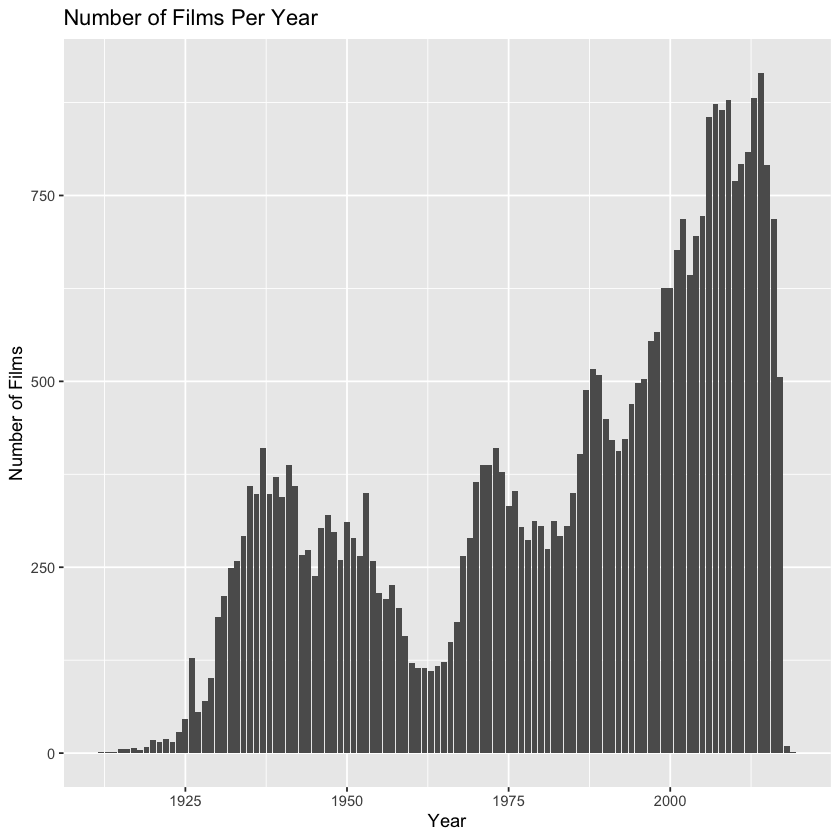

In [123]:
## Bar chart for films released per year## 

films_per_year_graph = number_films_per_year(unique_movies)
ggplot(films_per_year_graph, aes(x=year, y=count)) +
  geom_bar(stat = "identity", fill = "gray36") + labs(title = "Number of Films Per Year", x = "Year", y = "Number of Films")

In [177]:
## Bar chart for films released per month## 

plotMonthPerGivenYear <- function(data, year)
{
    monthly_films_all = number_films_per_month(data)
    
    if (is.null(year)) # no year given, so all the data
    { 
        ggplot(monthly_films_all, aes(x=month, y=count)) +
        geom_bar(stat = "identity", fill = "#f3ce13") + labs(title = "Monthly Distribution", x = "Month", y = "Number of Films")
    } 
    else # year given, need to compare year with overall
    { 
        year_films = data[which(data$year == year),]

        monthly_films_year = number_films_per_month(year_films) %>% mutate(compare=year)
        
        monthly_films_all = monthly_films_all %>% mutate(compare='All')
        
        combined_data = rbind(monthly_films_year, monthly_films_all)
        
        ggplot(combined_data, aes(x=month, y=count, fill=compare)) +
        geom_bar(stat='identity', position='dodge') + labs(title = "Monthly Distribution", x = "Month", y = "Number of Films")
        
    }
}    

[1] "---- total counted= 36596"
[1] "---- unique months= 12"
[1] "---- total counted= 769"
[1] "---- unique months= 12"
[1] "---- total counted= 36596"
[1] "---- unique months= 12"


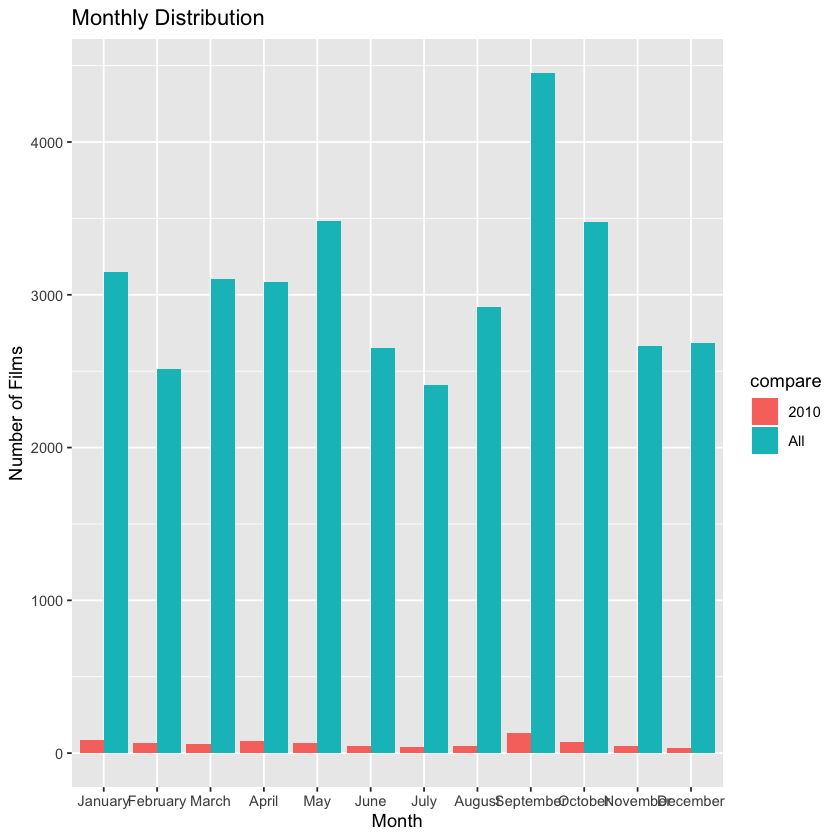

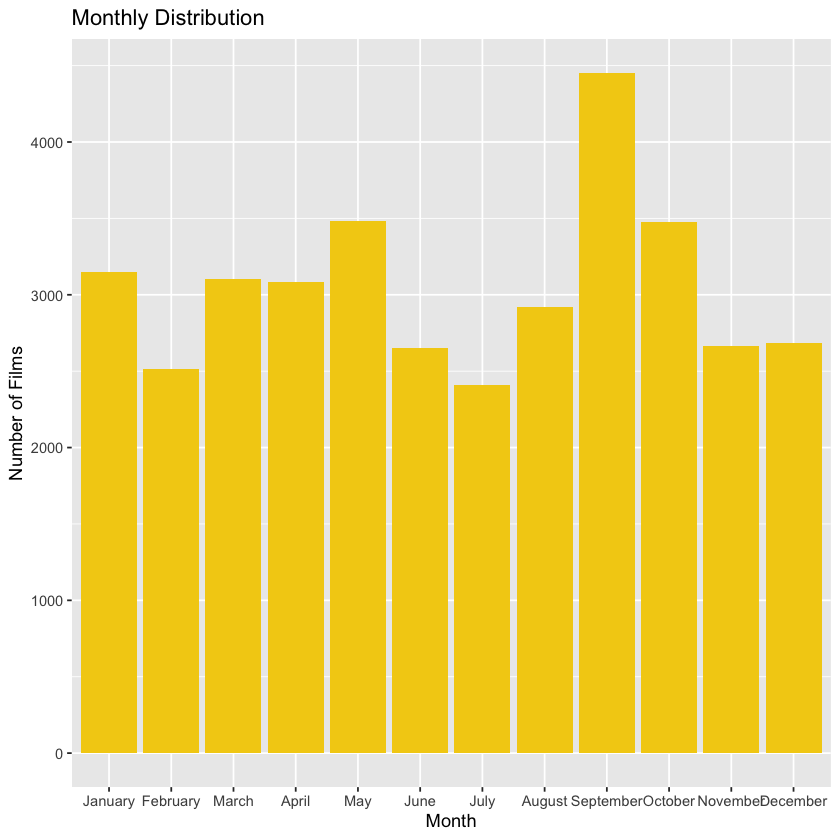

In [212]:
plotMonthPerGivenYear(unique_movies, 2010)
plotMonthPerGivenYear(unique_movies, NULL)

In [214]:
## Bar chart for distribution runtimes##

plotRuntimePerGivenYear <- function(data, year)
{
    runtime_distribution_all = distribution_of_runtimes(data)
    
    if (is.null(year)) # no year given, so all the data
    { 
        ggplot(runtime_distribution_all, aes(x=runtime, y=count)) +
        geom_point() + labs(title = "Runtime Distribution", x = "Runtime", y = "Number of Films")
    } 
    else # year given, need to compare year with overall
    { 
        year_films = data[which(data$year == year),]

        runtime_distribution_year =  distribution_of_runtimes(year_films) %>% mutate(compare=year)
        
        runtime_distribution_all = runtime_distribution_all %>% mutate(compare='All')
        
        combined_data = rbind(runtime_distribution_year, runtime_distribution_all)
        
        ggplot(combined_data, aes(x=runtime, y=count, color=compare)) +
        geom_point() + labs(title = "Runtime Distribution", x = "Runtime", y = "Number of Films")
        
    }
    
}


[1] "---- total counted= 36596"
[1] "---- unique runtimes= 395"
[1] "---- total counted= 769"
[1] "---- unique runtimes= 394"
[1] "---- total counted= 36596"
[1] "---- unique runtimes= 395"


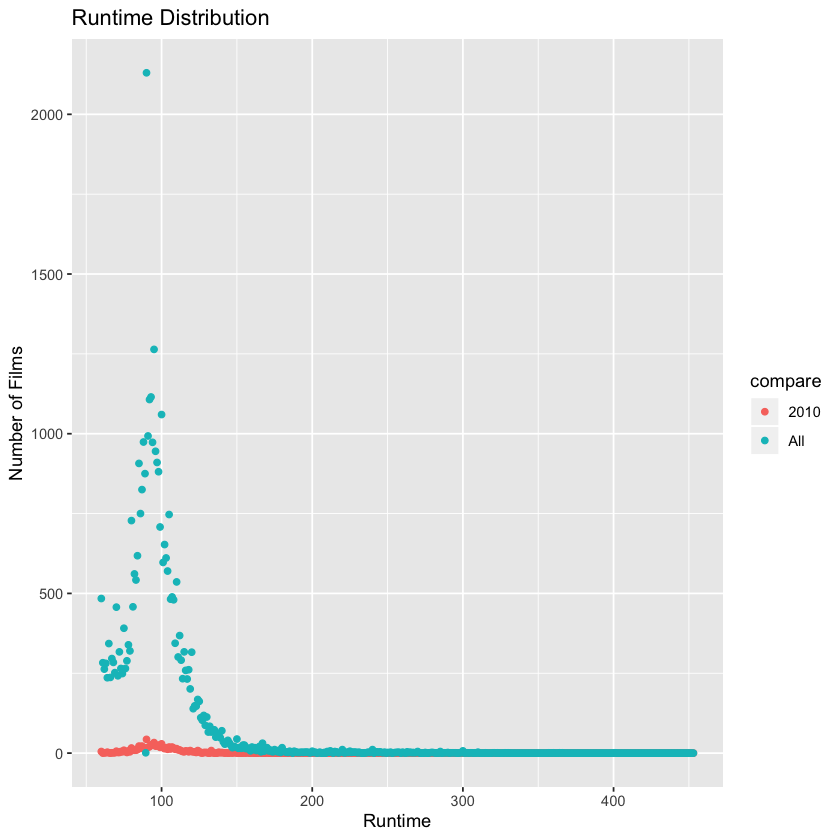

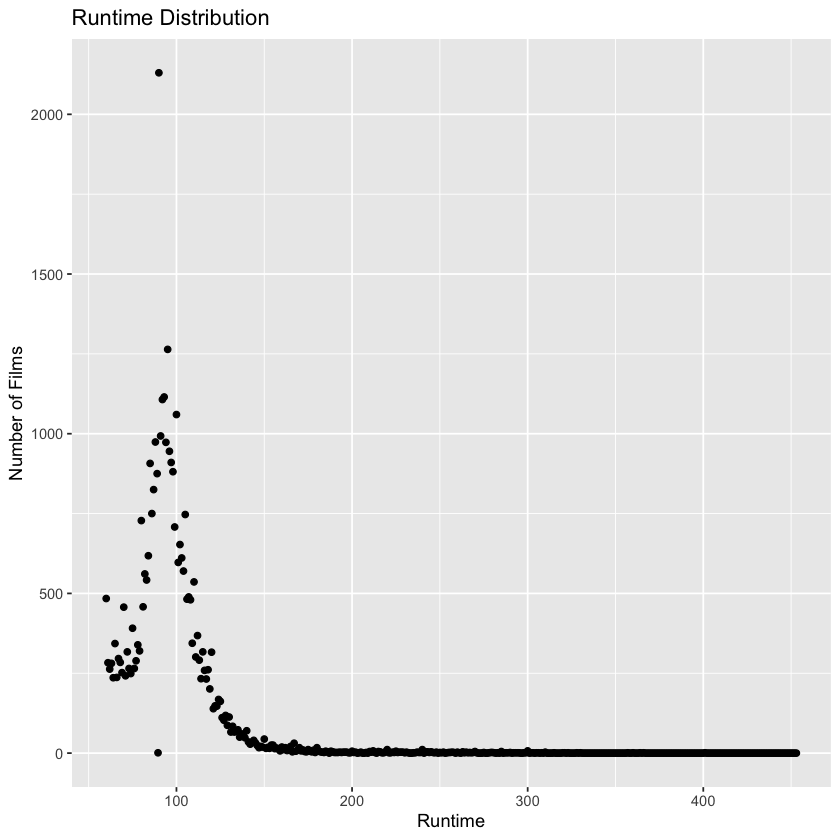

In [215]:
plotRuntimePerGivenYear(unique_movies, 2010)
plotRuntimePerGivenYear(unique_movies, NULL)

In [210]:
## Bar chart for distribution of genres ##

plotGenrePerYear <- function(data, year)
{
    genre_distribution_all = distribution_of_genres(data)
    
    if (is.null(year)) # no year given, so all the data
    { 
        ggplot(genre_distribution_all, aes(x=genre, y=count)) +
        geom_bar(stat='identity') + labs(title = "Genre Distribution", x = "Genre", y = "Number of Films")
    } 
    else # year given, need to compare year with overall
    { 
        year_films = data[which(data$year == year),]

        genre_distribution_year =  distribution_of_genres(year_films) %>% mutate(compare=year)
        
        genre_distribution_all = genre_distribution_all %>% 
                                filter(genre %in% genre_distribution_year$genre) %>% 
                                mutate(compare='All')
        
        combined_data = rbind(genre_distribution_year, genre_distribution_all)
        
        ggplot(combined_data, aes(x=genre, y=count, fill=compare)) +
        geom_bar(stat='identity', position='dodge') + labs(title = "Genre Distribution", x = "Genre", y = "Number of Films")
        
    }
}

[1] "---- total counted= 36596"
[1] "---- unique genres= 22"
[1] "---- total counted= 809"
[1] "---- unique genres= 17"
[1] "---- total counted= 36596"
[1] "---- unique genres= 22"


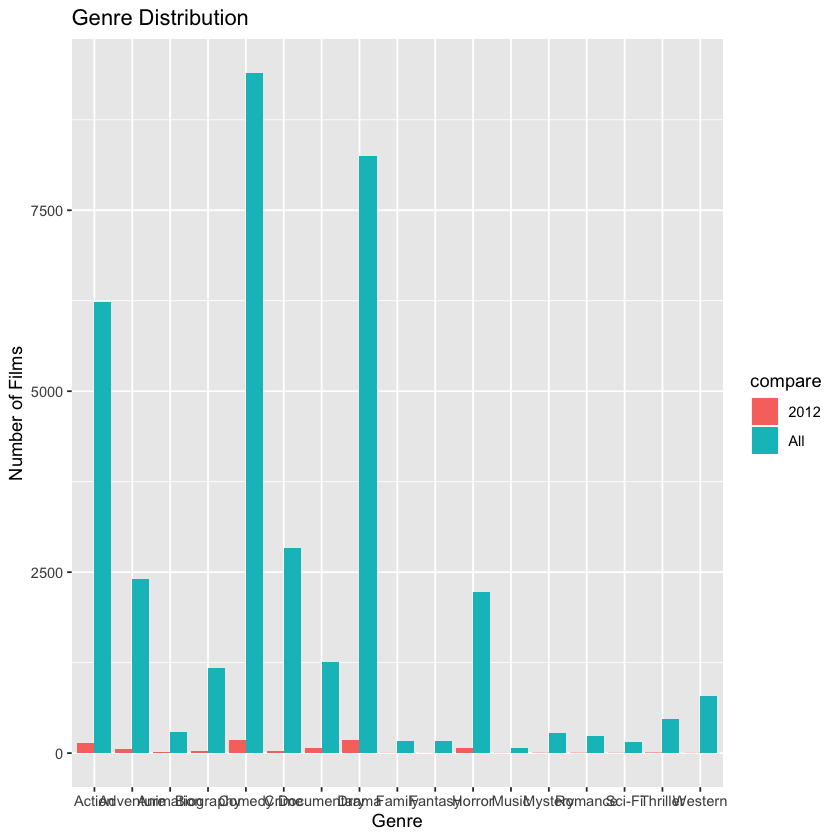

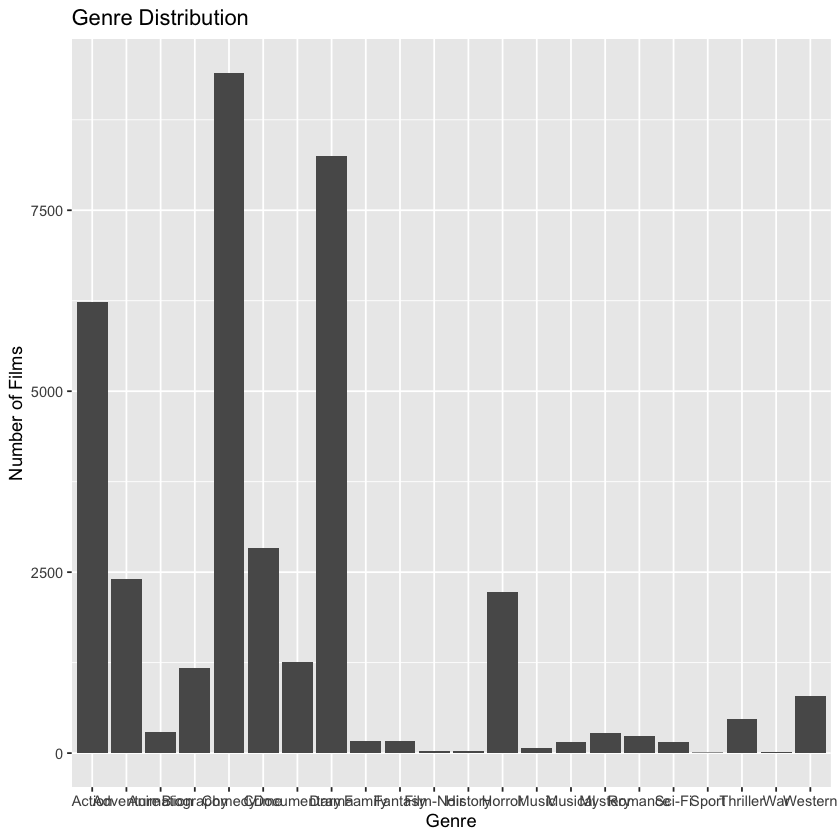

In [216]:
plotGenrePerYear(unique_movies, 2012)
plotGenrePerYear(unique_movies, NULL)

In [208]:
## Bar chart for distribution of certificates for a given movie ##

plotCertificatesPerYear <- function(data, year)
{
    certificate_distribution_all = distribution_of_certificates(data)
    
    if (is.null(year)) # no year given, so all the data
    { 
        
        ggplot(certificate_distribution_all, aes(x=rating, y=count)) +
        geom_bar(stat='identity') + labs(title = "Certificate Distribution", x = "Certificate", y = "Number of Films")
    } 
    else # year given, need to compare year with overall
    { 
        year_films = data[which(data$year == year),]

        certificate_distribution_year =  distribution_of_certificates(year_films) %>% mutate(compare=year)
        
        certificate_distribution_all = certificate_distribution_all %>% 
                                        filter(rating %in% certificate_distribution_year$rating) %>% 
                                        mutate(compare='All')
        
        combined_data = rbind(certificate_distribution_year, certificate_distribution_all)
        
        ggplot(combined_data, aes(x=rating, y=count, fill=compare)) +
        geom_bar(stat='identity', position='dodge') + labs(title = "Certificate Distribution", x = "Certificate", y = "Number of Films")
        
    }
}


[1] "---- total counted= 36596"
[1] "---- unique certificates= 12"
[1] "---- total counted= 809"
[1] "---- unique certificates= 7"
[1] "---- total counted= 36596"
[1] "---- unique certificates= 12"


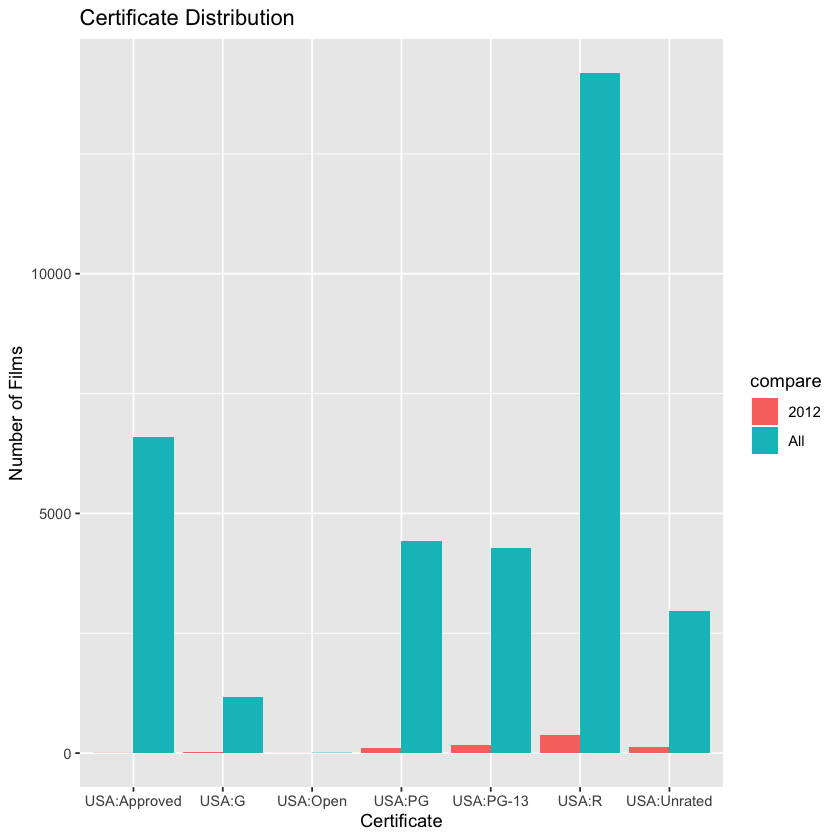

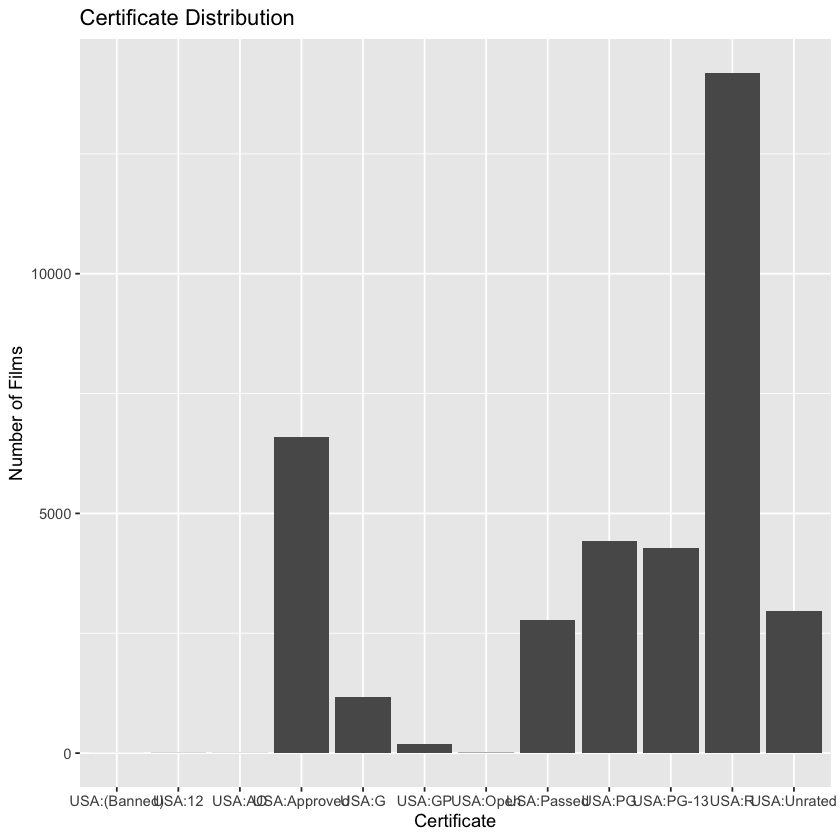

In [217]:
plotCertificatesPerYear(unique_movies, 2012)
plotCertificatesPerYear(unique_movies, NULL)

In [204]:
## Bar chart for distribution of N key words ##

plotTopKeywordsPerYear <- function(data, year, n)
{
    
    if (is.null(year)) # no year given, so all the data
    { 
        keyword_distribution_all = distribution_of_keywords(data, n)
        ggplot(keyword_distribution_all, aes(x=keyword, y=count)) +
        geom_bar(stat='identity') + labs(title = "Keyword Distribution", x = "Keyword", y = "Number of Films")
    } 
    else # year given, need to compare year with overall
    { 
        year_films = data[which(data$year == year),]

        keyword_distribution_year =  distribution_of_keywords(year_films, n) %>% mutate(compare=year)
        
        keyword_distribution_all = distribution_of_keywords(data, length(unique(data$keyword))) %>%
                                    filter(keyword %in% keyword_distribution_year$keyword) %>% mutate(compare='All') 
        
        combined_data = rbind(keyword_distribution_year, keyword_distribution_all)
        
        ggplot(combined_data, aes(x=keyword, y=count, fill=compare)) +
        geom_bar(stat='identity', position='dodge') + labs(title = "Keyword Distribution", x = "Keyword", y = "Number of Films")
        
    }
}

Selecting by count



[1] "---- total counted= 1049"
[1] "---- unique keywords= 10"


Selecting by count



[1] "---- total counted= 1750011"
[1] "---- unique keywords= 31305"


Selecting by count



[1] "---- total counted= 56048"
[1] "---- unique keywords= 10"


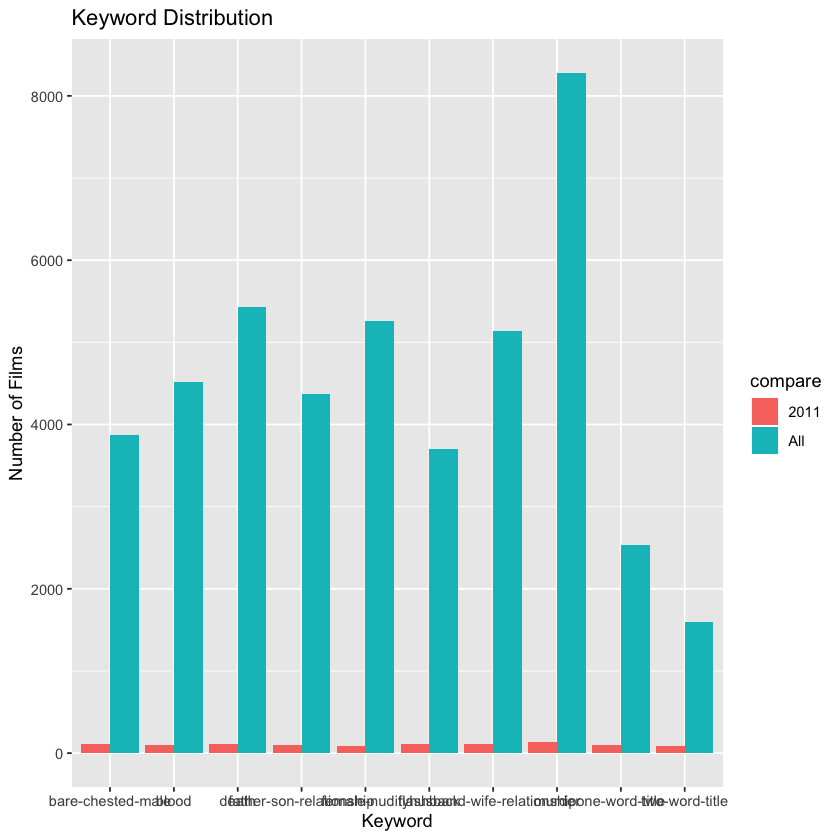

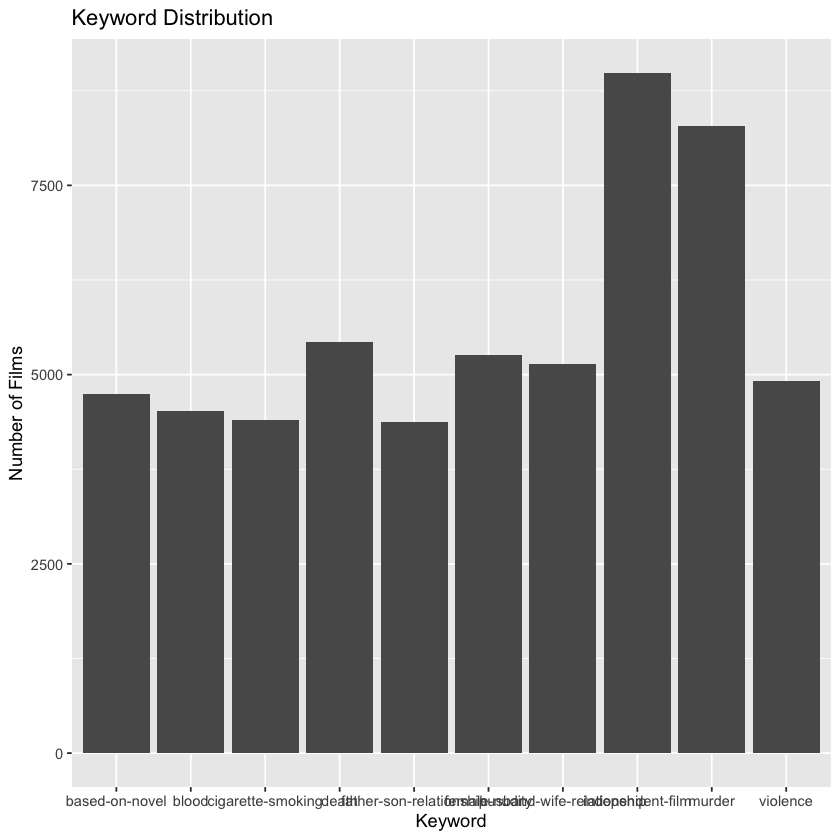

In [218]:
plotTopKeywordsPerYear(keywords_subset, 2011, 10)
plotTopKeywordsPerYear(keywords_subset, NULL, 10)